# Figure 2: Population and reports

The population density of Australia from the 2016 Census (top) and the number of reports in the SSA from Jan 2010 - Apr 2016 (bottom). Note the similarities between the two.

## Package imports

In [1]:
additional_package_lib <- "/scratch/w42/ig1052/rlibs"

suppressPackageStartupMessages({
  library(tidyverse)
  library(raster)
  library(tabularaster, lib.loc = additional_package_lib)
  library(sf)
  library(ozmaps, lib.loc = additional_package_lib)  
  library(scico)
  library(patchwork)
  library(latex2exp, lib.loc = additional_package_lib)
})

## Preparing data from the SSA

In [2]:
# the severe storms archive data
ssa <- read_csv("/g/data/w42/ig1052/bayesian_paper_data/clean_data/ssa_hail_060101-230125.csv", 
                col_types = "nTnnccnc")

In [3]:
# filtering to correct date range 
ssa_to_plot <- ssa %>%
  filter(date_time < "2016-05-01") %>%
  filter(date_time >= "2010-01-01") %>%
  # gridding to same brid
  mutate(latitude = floor(latitude * 4) / 4,
         longitude = floor(longitude * 4) / 4) %>%
  group_by(latitude, longitude) %>%
  # total per grid cell
  summarise(n = n(), .groups = "drop")

## Preparing population density data

In [4]:
# reading in the population density raster
pop_raster <- raster("/g/data/w42/ig1052/bayesian_paper_data/intermediate_data/population_density_coarse_grid.tif")
pop_raster <- setMinMax(pop_raster)

In [5]:
# raster to tibble
pop_tibble <- as_tibble(pop_raster, xy = TRUE) %>%
  drop_na(cellvalue)

## Plotting

In [6]:
# task for the population density scale
scale_line1 <- expression("Pop. dens.")
scale_line2 <- expression("[people km"^-2*"]")

# plotting the population density
p1 <- pop_tibble %>%
  # filtering out very low population densities for clarity
  filter(cellvalue > 1) %>%
  ggplot() + 
  # plotting
  geom_tile(aes(x = x, y = y, fill = cellvalue)) +
  # adding in state boundaries
  geom_sf(data = ozmap_states, color = "black", fill = NA) + 
  # scaling appropriately
  coord_sf() +
  # labelling
  xlab("Longitude [degrees east]") + 
  ylab("Latitude [degrees south]") +
  # scale colour palette
  scale_fill_scico(bquote("Pop. dens.\n[people"*km^-2*"]"), palette = "batlow", trans = "log10") +
  # overall size
  theme_gray(base_size = 15) +
  # plot margins
  theme(#plot.margin = unit(c(0.1, 3, 0.1, 0.1), "cm"),
        #legend.margin = margin(0, 0, 0, 0),
        legend.key.height = unit(2, "cm"))

In [8]:
# plotting ssa reports around Australia
p2 <- ssa_to_plot %>%
  ggplot() + 
  # including ssa
  geom_rect(aes(xmin = longitude, xmax = longitude + 0.25, ymin = latitude, ymax = latitude + 0.25, fill = n)) +
  # adding states
  geom_sf(data = ozmap_states, color = "black", fill = NA) + 
  # scaling appropriately
  coord_sf() +
  # colour scale
  scale_fill_scico("Total\nreports", palette = "batlow") +
  # labelling
  xlab("Longitude [degrees east]") + 
  ylab("Latitude [degrees south]") +
  # size
  theme_gray(base_size = 15) +
  # stretch legend
  theme(legend.key.height = unit(2, "cm"))

Warning message:
“Removed 4020 rows containing missing values (`geom_tile()`).”
Warning message:
“Removed 206 rows containing missing values (`geom_rect()`).”


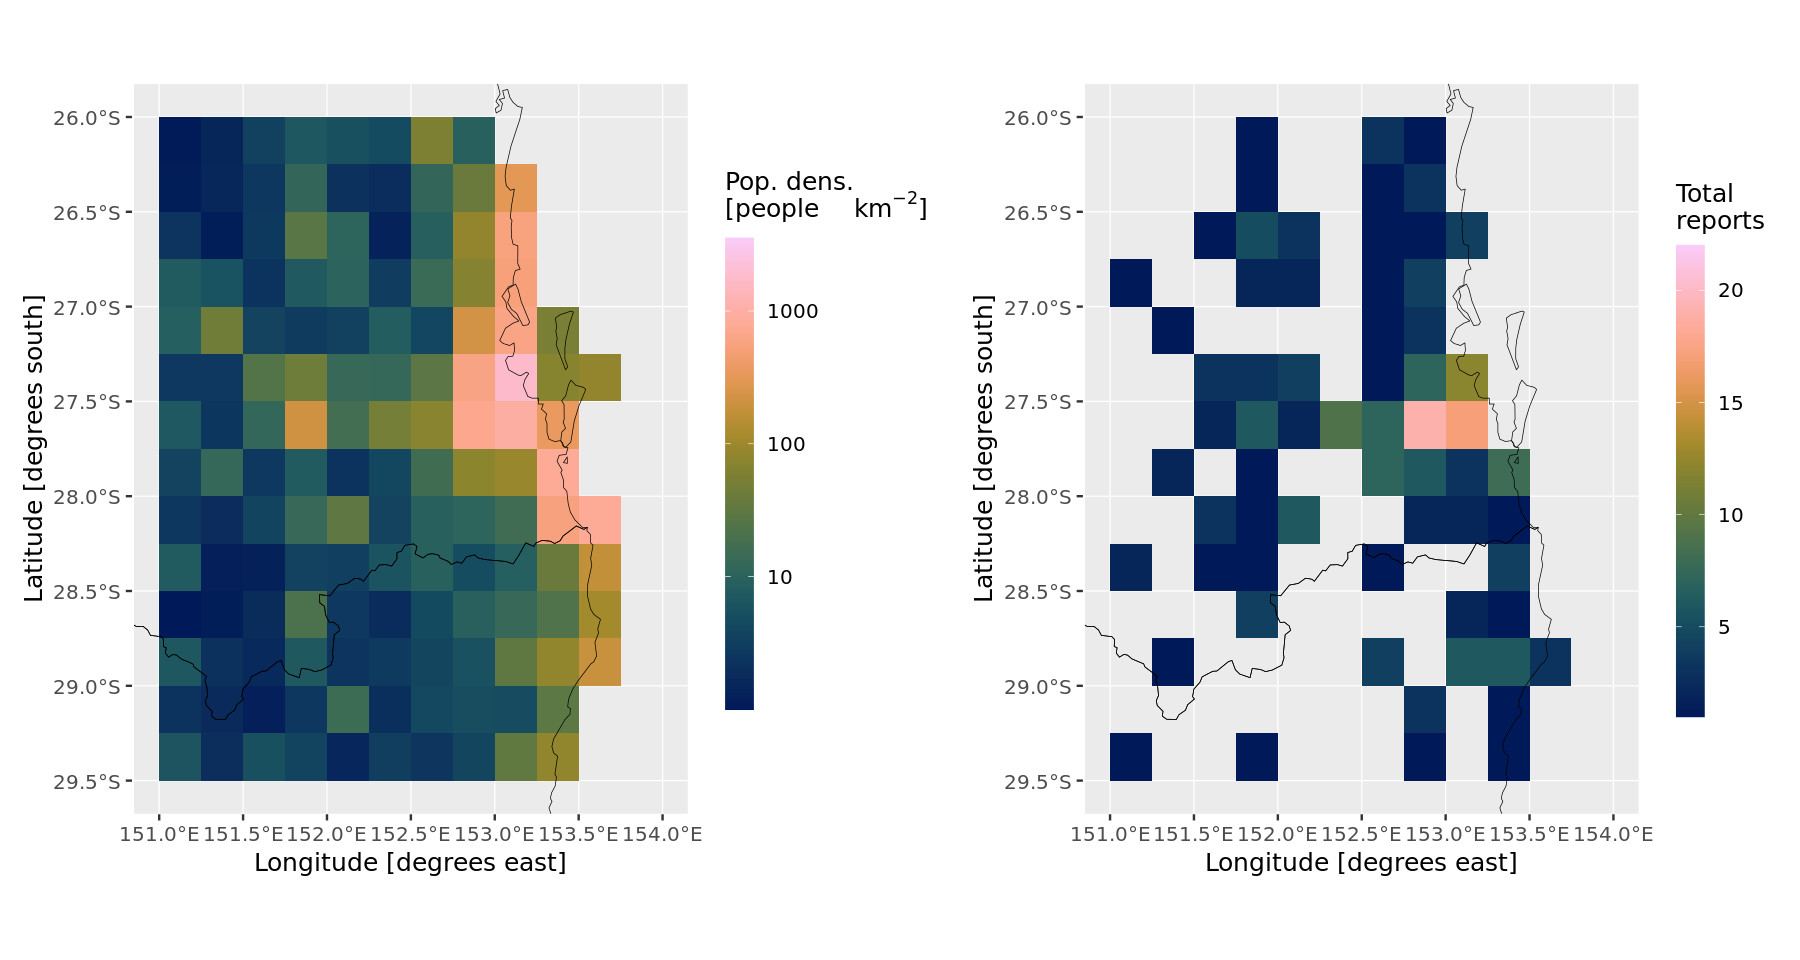

In [14]:
# viewing size
options(repr.plot.height = 8, repr.plot.width = 15)

# plots one above the other
(p1 +
  xlim(c(151, 154)) +
  ylim(c(-29.5, -26))) +
(p2 +
  xlim(c(151, 154)) +
  ylim(c(-29.5, -26)))